In [2]:
using CairoMakie;
using DelimitedFiles, StatsBase, Statistics, LazySets, Glob, LaTeXStrings, Printf, NLsolve;
include("analysis/3spec_analysis_library.jl");

┌ Warning: `.px_area` got renamed to `.viewport`, and means the area the scene maps to in device independent units, not pixels. Note, `size(scene) == widths(scene.viewport[])`
└ @ Makie /Users/federica/.julia/packages/Makie/ux0Te/src/deprecated.jl:17
┌ Warning: `.px_area` got renamed to `.viewport`, and means the area the scene maps to in device independent units, not pixels. Note, `size(scene) == widths(scene.viewport[])`
└ @ Makie /Users/federica/.julia/packages/Makie/ux0Te/src/deprecated.jl:17


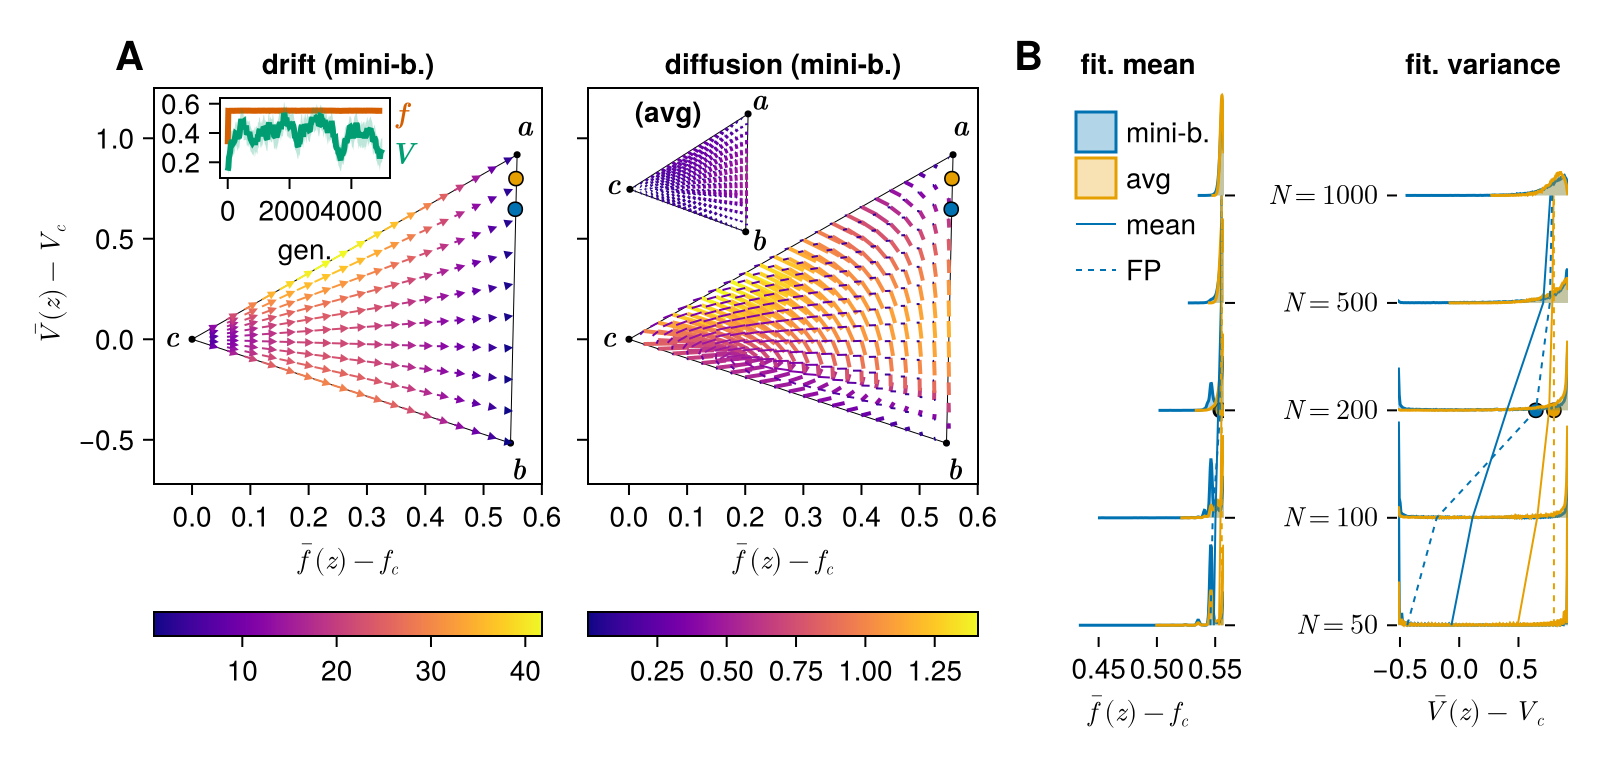

In [ ]:
nu = 0.001
N = 200
as = 6
ls = 0.0009
xstep = 0.025
xstep_dr = 0.03

tini = 75

# fetch the right simulation data
fastring = "fa1.01*"
listdir = glob("data/*"*"nu$(nu)*"*fastring)

land_vec = readdlm(pwd()*"/"*listdir[1]*"/landvec.txt")
avg_vec = copy(transpose(mean(land_vec, dims=1)))
var_vec = copy(transpose(var(land_vec, dims=1)))

# plot the landscapes
f = Figure(backgroundcolor = RGBf(1,1,1), size = (800, 380))
gde = f[1, 1] = GridLayout()
gdr = gde[1,1] = GridLayout()
gdi = gde[1,2] = GridLayout()
g2 = f[1,2] = GridLayout()
adr = Axis(gdr[1, 1], xgridvisible = false, ygridvisible = false)
adi = Axis(gdi[1, 1], xgridvisible = false, ygridvisible = false)
hideydecorations!(adi,ticklabels = true, ticks=false)
avio = [Axis(g2[1, i], xgridvisible = false, ygridvisible = false) for i in 1:2]
[ad.xlabel = L"\bar{f}(z) - f_c" for ad in [adr, adi]]
adr.ylabel = L"\bar{V}(z) - V_c" 
adr.title = "drift (mini-b.)"
adi.title = "diffusion (mini-b.)"
max = maximum(land_vec)
formatted_fa = @sprintf("%.2f", avg_vec[1,1])
formatted_fb = @sprintf("%.2f", avg_vec[2,1])
formatted_fc = @sprintf("%.2f", avg_vec[3,1])
formatted_Va = @sprintf("%.2f", var_vec[1,1])
formatted_Vb = @sprintf("%.2f", var_vec[2,1])
formatted_Vc = @sprintf("%.2f", var_vec[3,1])

slope1 = (var_vec[2,1]-var_vec[3,1])/(avg_vec[2,1]-avg_vec[3,1])
slope2 = (var_vec[1,1]-var_vec[3,1])/(avg_vec[1,1]-avg_vec[3,1])
points = reduce(vcat,[[Point2f(x, y) for y in range(slope1*x,slope2*x,minimum([10,Int(floor((slope2-slope1)*x/0.015))]))] for x in 0:xstep_dr:maximum(avg_vec)-avg_vec[3,1]])

# drift plot
scatter!(adr,mean(land_vec,dims=1)[1,:].-avg_vec[3,1],var(land_vec,dims=1)[1,:].-var_vec[3,1],markersize=5,color=:black)
lines!(adr,push!(avg_vec[:,1],avg_vec[1,1]).-avg_vec[3,1],push!(var_vec[:,1],var_vec[1,1]).-var_vec[3,1],color=:black,linewidth=0.5)
v = [drift_pt(x) for x in points]
strength = [norm(v[i]) for i in 1:length(v)]
a1 = arrows!(adr,points,v, arrowsize = as, lengthscale = ls, arrowcolor = strength, linecolor = strength, colormap = cgrad(:plasma))
text!(adr,0.35,1.05,text=L"$\mathbf{f}$",color=Makie.wong_colors()[6])
text!(adr,0.34,0.85,text=L"\mathbf{V}",color=Makie.wong_colors()[3]) 

Colorbar(gdr[2,1],a1,vertical=false,flipaxis = false)

[ylims!(ad,-0.72,1.25) for ad in [adr,adi]]

# inset evo
N = 200
ncopies = 50

dir = glob("data/N$(N)_*"*fastring)[1]
F = []
V = []

for n in 1:ncopies
    pop = readdlm(pwd()*"/"*dir*"/balanced/copy_$(n)/pop.txt")[:,2:end]./N
    favg = pop*avg_vec
    vavg = pop*var_vec
    append!(F,favg[:,1])
    append!(V,vavg[:,1])
end

bboxf = lift(adr.scene.camera.projectionview, adr.scene.px_area) do _, pxa
    p = Makie.project(adr.scene, Point(0.34, 1.2))
    c = p + pxa.origin
    Rect2f(c .- Point2f(85, 40), (85, 40))
end
axinf = Axis(f, bbox = bboxf,xgridvisible = false,ygridvisible = false)

Fres = reshape(F.-avg_vec[3,1], Int(length(F)/ncopies),ncopies)
lines!(axinf,0:20:5000,mean(Fres,dims=2)[:,1],linewidth=3,color=Makie.wong_colors()[6])
band!(axinf,0:20:5000,mean(Fres,dims=2)[:,1].-std(Fres,dims=2)[:,1]./sqrt(ncopies),mean(Fres,dims=2)[:,1].+std(Fres,dims=2)[:,1]./sqrt(ncopies),
    color=Makie.wong_colors()[6],alpha=0.5)
Vres = reshape(V.-var_vec[3,1], Int(length(V)/ncopies),ncopies)
lines!(axinf,0:20:5000,mean(Vres,dims=2)[:,1],linewidth=3,color=Makie.wong_colors()[3])
band!(axinf,0:20:5000,mean(Vres,dims=2)[:,1].-std(Vres,dims=2)[:,1]./sqrt(ncopies),mean(Vres,dims=2)[:,1].+std(Vres,dims=2)[:,1]./sqrt(ncopies),
    color=Makie.wong_colors()[3],alpha=0.5)
axinf.xlabel="gen."
tight_xticklabel_spacing!(axinf)

# diffusion plot
scatter!(adi,mean(land_vec,dims=1)[1,:].-avg_vec[3,1],var(land_vec,dims=1)[1,:].-var_vec[3,1],markersize=5,color=:black)
lines!(adi,push!(avg_vec[:,1],avg_vec[1,1]).-avg_vec[3,1],push!(var_vec[:,1],var_vec[1,1]).-var_vec[3,1],color=:black,linewidth=0.5)

points_diff = reduce(vcat,[[Point2f(x, y) for y in range(slope1*x,slope2*x,maximum([1,minimum([15,Int(floor((slope2-slope1)*x/0.03))])]))] for x in 0.025:xstep:maximum(avg_vec)-avg_vec[3,1]])
spmax = [diffmax_pt(x) for x in points_diff]
strength_max = [norm(spmax[i]) for i in 1:length(spmax)]
spmin = [diffmin_pt(x) for x in points_diff]
strength_min = [norm(spmin[i]) for i in 1:length(spmin)]

spmax0 = [diffmax0_pt(x) for x in points_diff]
strength_max0 = [norm(spmax0[i]) for i in 1:length(spmax0)]
spmin0 = [diffmin0_pt(x) for x in points_diff]
strength_min0 = [norm(spmin0[i]) for i in 1:length(spmin0)]

cmin = minimum([minimum(strength_min), minimum(strength_min0)])
cmax = maximum([maximum(strength_max), maximum(strength_max0)])
a2 = arrows!(adi,points_diff,spmax, arrowsize = 0, lengthscale = 0.07, arrowcolor = strength_max, linecolor = strength_max, 
    colormap = cgrad(:plasma),linewidth=2, align=:origin, colorrange = (cmin, cmax))
arrows!(adi,points_diff,spmin, arrowsize = 0, lengthscale = 0.07, arrowcolor = strength_min, linecolor = strength_min, 
    colormap = cgrad(:plasma),linewidth=1, align = :center, colorrange = (cmin, cmax))

Colorbar(gdi[2,1],a2,vertical=false,flipaxis = false)

bbox = lift(adi.scene.camera.projectionview, adi.scene.px_area) do _, pxa
    p = Makie.project(adi.scene, Point(0.18, 1.05))
    c = p + pxa.origin
    Rect2f(c .- Point2f(55, 55), (65, 65))
end

text!(adi,-0.04,0.7,text=L"$\mathbf{c}$")
text!(adi,0.21,0.42,text=L"$\mathbf{b}$")
text!(adi,0.21,1.12,text=L"$\mathbf{a}$")

axin = Axis(f, bbox = bbox,xgridvisible = false,ygridvisible = false)
hidedecorations!(axin)
text!(adi,0.01,1.05,text="(avg)",font=:bold)
hidespines!(axin)
scatter!(axin,mean(land_vec,dims=1)[1,:].-avg_vec[3,1],var(land_vec,dims=1)[1,:].-var_vec[3,1],markersize=5,color=:black)
lines!(axin,push!(avg_vec[:,1],avg_vec[1,1]).-avg_vec[3,1],push!(var_vec[:,1],var_vec[1,1]).-var_vec[3,1],color=:black,linewidth=0.5)

arrows!(axin,points_diff,spmax0, arrowsize = 0, lengthscale = 0.15, arrowcolor = strength_max0, linecolor = strength_max0, 
    colormap = cgrad(:plasma),linewidth=1.5, align=:origin, colorrange = (cmin, cmax))
arrows!(axin,points_diff,spmin0, arrowsize = 0, lengthscale = 0.15, arrowcolor = strength_min0, linecolor = strength_min0, 
    colormap = cgrad(:plasma),linewidth=0.75, align = :center, colorrange = (cmin, cmax))

sol = fixed(avg_vec,var_vec,nu,N)
sol0 = fixed0(avg_vec,var_vec,nu)

P = copy(sol.zero)
P0 = copy(sol0.zero)

scatter!(adr,P[1],P[2],markersize=10,color=Makie.wong_colors()[1],strokecolor=:black, strokewidth=0.8)
scatter!(adi,P[1],P[2],markersize=10,color=Makie.wong_colors()[1],strokecolor=:black, strokewidth=0.8)
scatter!(adr,P0[1],P0[2],markersize=10,color=Makie.wong_colors()[2],strokecolor=:black, strokewidth=0.8)
scatter!(adi,P0[1],P0[2],markersize=10,color=Makie.wong_colors()[2],strokecolor=:black, strokewidth=0.8)

for ad in [adr,adi]
    text!(ad,-0.035,0.01,text=L"$\mathbf{c}$",align=(:center,:center))
    text!(ad,0.56,-0.65,text=L"$\mathbf{b}$",align=(:center,:center))
    text!(ad,0.57,1.06,text=L"$\mathbf{a}$",align=(:center,:center))
end

# density plots
Narr = [50,100,200,500,1000]

scatter!(avio[2],[P[2]],[90],markersize=10,color=Makie.wong_colors()[1],strokecolor=:black, strokewidth=0.8)
scatter!(avio[2],[P0[2]],[90],markersize=10,color=Makie.wong_colors()[2],strokecolor=:black, strokewidth=0.8)
scatter!(avio[1],[P[1]],[900],markersize=10,color=Makie.wong_colors()[1],strokecolor=:black, strokewidth=0.8)
scatter!(avio[1],[P0[1]],[900],markersize=10,color=Makie.wong_colors()[2],strokecolor=:black, strokewidth=0.8)

avio[1].title = "fit. mean"
avio[2].title = "fit. variance"
listdir = [glob("data/N$(N)_*"*fastring) for N in [50,100,200,500,1000]]
i = 1
meanf = []
meanv = []
meanf_ref = []
meanv_ref = []
for dir in listdir
    F = []
    V = []
    Fref = []
    Vref = []
    N = parse(Int,split(split(dir[1],"N")[2],"_")[1])
    for n in 1:ncopies
        pop = readdlm(pwd()*"/"*dir[1]*"/balanced/copy_$(n)/pop.txt")[tini:end,2:end]./N
        pop_ref = readdlm(pwd()*"/"*dir[1]*"/balanced/copy_$(n)/pop_ref.txt")[tini:end,2:end]./N
        favg = pop*avg_vec
        favg_ref = pop_ref*avg_vec
        vavg = pop*var_vec
        vavg_ref = pop_ref*var_vec   
        append!(F,favg[:,1])
        append!(Fref,favg_ref[:,1])
        append!(V,vavg[:,1])
        append!(Vref,vavg_ref[:,1])
    end
    if i==1 
        density!(avio[1],F.-avg_vec[3,1],bandwidth=0.001,color=(Makie.wong_colors()[1],0.3), strokewidth=1.5, offset=300*i, strokecolor=Makie.wong_colors()[1],label="mini-b.")
        density!(avio[1],Fref.-avg_vec[3,1],bandwidth=0.001,color=(Makie.wong_colors()[2],0.3), strokewidth=1.5, offset=300*i,strokecolor=Makie.wong_colors()[2], label="avg")
    else
        density!(avio[1],F.-avg_vec[3,1],bandwidth=0.001,color=(Makie.wong_colors()[1],0.3), strokewidth=1.5, offset=300*i, strokecolor=Makie.wong_colors()[1])
        density!(avio[1],Fref.-avg_vec[3,1],bandwidth=0.001,color=(Makie.wong_colors()[2],0.3), strokewidth=1.5, offset=300*i,strokecolor=Makie.wong_colors()[2])
    end
    density!(avio[2],V.-var_vec[3,1],bandwidth=0.001,color=(Makie.wong_colors()[1],0.3), strokewidth=1.5, offset=30*i,strokecolor=Makie.wong_colors()[1])
    density!(avio[2],Vref.-var_vec[3,1],bandwidth=0.001,color=(Makie.wong_colors()[2],0.3), strokewidth=1.5, offset=30*i,strokecolor=Makie.wong_colors()[2])
    push!(meanf,mean(F.-avg_vec[3,1]))
    push!(meanv,mean(V.-var_vec[3,1]))
    push!(meanf_ref,mean(Fref.-avg_vec[3,1]))
    push!(meanv_ref,mean(Vref.-var_vec[3,1]))
    i+=1
end
xlims!(avio[1],0.41,avg_vec[1,1]-avg_vec[3,1])
xlims!(avio[2],var_vec[2,1]-var_vec[3,1],var_vec[1,1]-var_vec[3,1])
avio[1].xlabel = L"\bar{f}(z) - f_c"
avio[2].xlabel = L"\bar{V}(z) - V_c"
ylims!(avio[1],270,1800)
ylims!(avio[2],27,180)
[hidespines!(avio[i]) for i in 1:2]
avio[1].yaxisposition = :right
avio[1].yticklabelsvisible = false
avio[1].yticks = range(1,length(Narr)).*300
avio[2].yticks = (range(1,length(Narr)).*30, [L"N=%$(N)" for N in Narr])

lines!(avio[1],meanf, range(1,length(Narr)).*300, color = Makie.wong_colors()[1],linewidth=1,label="mean")
lines!(avio[1],meanf_ref, range(1,length(Narr)).*300, color = Makie.wong_colors()[2],linewidth=1)
lines!(avio[2],meanv, range(1,length(Narr)).*30, color = Makie.wong_colors()[1],linewidth=1)
lines!(avio[2],meanv_ref, range(1,length(Narr)).*30, color = Makie.wong_colors()[2],linewidth=1)

fixed_f = []
fixed_v = []
fixed_f0 = []
fixed_v0 = []
for N in Narr
    sol = fixed(avg_vec,var_vec,nu,N)
    push!(fixed_f,sol.zero[1])
    push!(fixed_v,sol.zero[2])
    sol0 = fixed0(avg_vec,var_vec,nu)
    push!(fixed_f0,sol0.zero[1])
    push!(fixed_v0,sol0.zero[2])
end
lines!(avio[1],fixed_f, range(1,length(Narr)).*300, color = Makie.wong_colors()[1],linewidth=1,linestyle=:dash,label="FP")
lines!(avio[2],fixed_v, range(1,length(Narr)).*30, color = Makie.wong_colors()[1],linewidth=1,linestyle=:dash)
lines!(avio[1],fixed_f0, range(1,length(Narr)).*300, color = Makie.wong_colors()[2],linewidth=1,linestyle=:dash)
lines!(avio[2],fixed_v0, range(1,length(Narr)).*30, color = Makie.wong_colors()[2],linewidth=1,linestyle=:dash)
axislegend(avio[1],position=:lt,framevisible = false)


for (label, layout) in zip(["A", "B"], [gde, g2])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 20,
        font = :bold,
        padding = (0, 5, 5, 0),
        halign = :right)
end

colsize!(f.layout, 1, Auto(1.6))

save("fig3spec_3.pdf",f)

f  